# Deep learning, but not understanding

CAP 6635 Artifical Intelligence Spring 2021
Christian Garbin

In the book "Artifical Intelligence, a giude for thinking humans" (Melanie Mitchell) explains that

> "Learning in neural networks simply consists in gradually modifying the weights on connections so that each output’s error gets as close to 0 as possible on all training examples."

Is that really "learning"?

Let's explore that idea.

Credit where credit is due: all quoted text comes from Micthell's excellent book.

## An extremely short explanation of deep learning

Deep learning uses layers of "units" (also called "neurons", but some people, including Mitchell and me, prefer the more generic "units" term, to not confuse with actual neurons) to extract patterns from labeled data. The internal layers are called "hidden layers". The last layer is called the "output layer", or the classification layer.

In the following figure (from Mitchell's book), a neural network comprised of several hidden layers (only one shown) was trained to classify handwritten digits. The output layer has ten units, one for each possible digit.

![Neural network](pics/neural-network.png)

## Back to "learning"

> "Learning in neural networks simply consists in gradually modifying the weights on connections so that each output’s error gets as close to 0 as possible on all training examples."

Disentagling the sentence a bit:

- "training examples": the labeled examples we present to the network to train it. For example we present a picture of a square or a triangle and its corresponding label, "square" or "triangle", respectively.
- "output's error": how far the network's prediction is from the correct label of the example picture.
- "weights on connections": a fine-precision decimal number (several digits after the dot) that adjusts the output of a unit in one layer to the input of a neuron in the next layer. The weights is where the "knowledge" of the neural network is encoded.
- "gradually modifying": this is the learning process. An algorithm carefully modifies the weights on the connections to get closer to the expected output. Repeating the adjustment step over time (many, many times) allows the network to learn from the training examples.

An important consequence of this process:

> The machine learns what it observes in the data rather than what you (the human) might observe. If there are statistical associations in the training data, even if irrelevant to the task at hand, the machine will happily learn those instead of what you wanted it to learn.

Thus, neural networks are not "learning" in the sense that we would understand the term. They are not learning higher-level concepts from the samples used to train them. They are extracting patterns from the data presented to them during training (and they assume that the labels are correct). That's all.

Or, as Mitchell puts more eloquently:

> The phrase “barrier of meaning” perfectly captures an idea that has permeated this book: humans, in some deep and essential way, understand the situations they encounter, whereas no AI system yet possesses such understanding. While state-of-the-art AI systems have nearly equaled (and in some cases surpassed) humans on certain narrowly defined tasks, these systems all lack a grasp of the rich meanings humans bring to bear in perception, language, and reasoning. This lack of understanding is clearly revealed by the un-humanlike errors these systems can make; by their difficulties with abstracting and transferring what they have learned; by their lack of commonsense knowledge; and by their vulnerability to adversarial attacks. The barrier of meaning between AI and human-level intelligence still stands today.

Should we be concerend that deep learning is not "learning"? We should, if we don't understand what it implies for real-life applications.

In the next sections we will explore how neural networks lacks the grasp of "rich meanings we humans bring to bear in perception", illustrating it with some "un-humanlike errors these systems can make; by their difficulties with abstracting and transferring what they have learned; by their lack of commonsense knowledge".

## Telling squares and triangles apart

We will see how a neural network trained to tell squares and triangles apart behaves.

For human beings, the pictures below show squares and triangles. Some are upright, some are rotated, some are in a light background, some are in a darker background. But they are all clearly either a square or a triangle in a frame.

![Squares and triangles](pics/squares-triangles.png)


In this section we will go through the typical process of training a neural network:

1. Get a labeled dataset
1. Split the dataset into a training set and a test set
1. Train the network with the training set
1. Validate its accuracy with the test set

After we are done with that, we will predict similar, but not exactly the same, images to see how the network handles them.

First, load some of the frameworks we need and prepare the environment.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import images

%matplotlib inline

# To increase reproducibility (although it's not guaranteed)
# Based on https://stackoverflow.com/a/52897216
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
                   
images.create_datasets()             

### The "squares vs. triangles" training examples

Load the square and triangle training examples.

In [2]:
(train_set, train_label), (test_set, test_label) = images.get_upright_dataset(10)
class_names = images.get_class_labels()

This is how the training examples look like. Each picture is a square or a traingle in different positions.

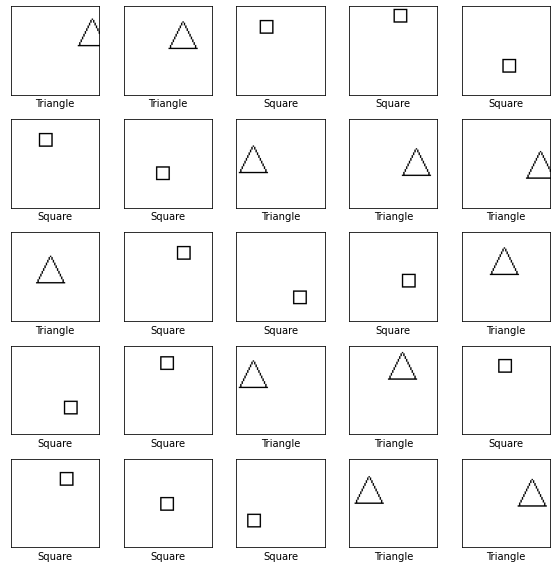

In [3]:
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_set[i], cmap='gray')
    plt.xlabel(class_names[train_label[i]])
plt.tight_layout()
plt.show()

### The "square vs. triangle" neural network

We will now train a neural network to classify a picture as a "square" or as a "triangle", using the training examples.

The code is based on the [TensorFlow classification tutorial](https://www.tensorflow.org/tutorials/keras/classification) and the [TensorFlow CNN classification tutorial](https://www.tensorflow.org/tutorials/images/cnn).

In [4]:
train_set, train_label = images.prepare_set(train_set, train_label)
test_set, test_label = images.prepare_set(test_set, test_label)

In [5]:
INPUT_SHAPE = (images.CANVAS_SIZE, images.CANVAS_SIZE, 1)
NUM_CLASSES = len(class_names)

def get_model():
    """Return a compiled model, ready to be trained."""
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                               input_shape=INPUT_SHAPE),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return model


In [6]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2, verbose=1,
    restore_best_weights=True)

In [7]:
BATCH_SIZE = 64
EPOCHS = 5

model = get_model()
model.fit(train_set, train_label, batch_size=BATCH_SIZE, epochs=EPOCHS,
          validation_data=(test_set, test_label), callbacks=[callback])

Epoch 1/5
10/10 [==============================] - 3s 297ms/step - loss: 1.1562 - accuracy: 0.4473 - val_loss: 0.6914 - val_accuracy: 0.4925
Epoch 2/5
10/10 [==============================] - 2s 236ms/step - loss: 0.6774 - accuracy: 0.5618 - val_loss: 0.6924 - val_accuracy: 0.4925
Epoch 3/5
10/10 [==============================] - 3s 262ms/step - loss: 0.5801 - accuracy: 0.6770 - val_loss: 0.4654 - val_accuracy: 0.8209
Epoch 4/5
10/10 [==============================] - 2s 237ms/step - loss: 0.3118 - accuracy: 0.9256 - val_loss: 0.2652 - val_accuracy: 0.8806
Epoch 5/5
10/10 [==============================] - 2s 223ms/step - loss: 0.1456 - accuracy: 0.9613 - val_loss: 0.1061 - val_accuracy: 0.9701


In [8]:
pred_prob = model.predict(test_set)
pred_label = np.argmax(pred_prob, axis=1)

In [9]:
print(pred_label)
print(len(pred_label))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1]
67


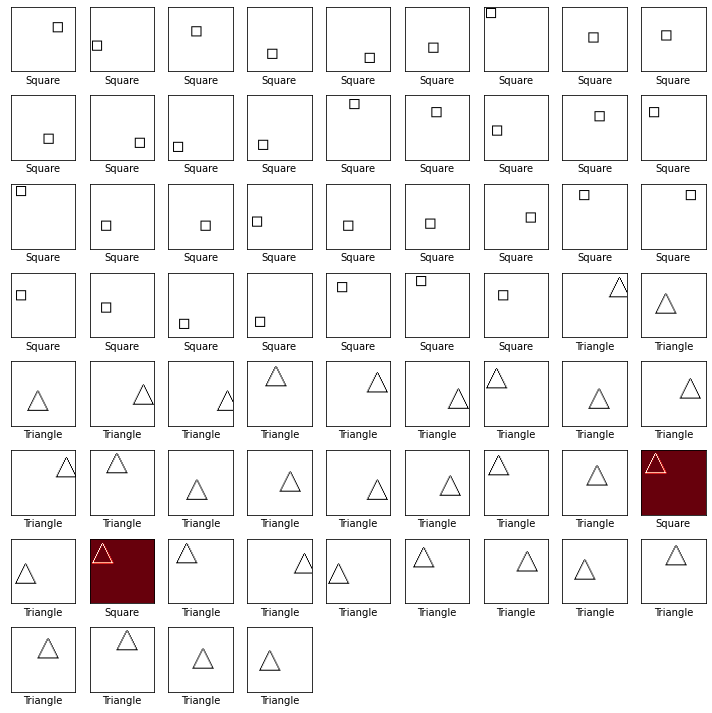

In [10]:
plt.figure(figsize=(10,10))
for i in range(67):
    plt.subplot(8,9,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cmap = 'gray' if pred_label[i] == test_label[i][0] else 'Reds'
    plt.imshow(test_set[i], cmap=cmap, vmin=0.0, vmax=1.0)
    plt.xlabel(class_names[pred_label[i]])
plt.tight_layout()
plt.show()

## When squares are not squares

When they are rotated. At least for this neural network.

In [11]:
rotated_squares = images.get_square_rotated_dataset()
rotated_squares, _ = images.prepare_set(rotated_squares)

In [12]:
pred_prob = model.predict(rotated_squares)
pred_label = np.argmax(pred_prob, axis=1)

In [13]:
print(pred_label)
print(len(pred_label))

[1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1
 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 0 1 0 1 0]
88


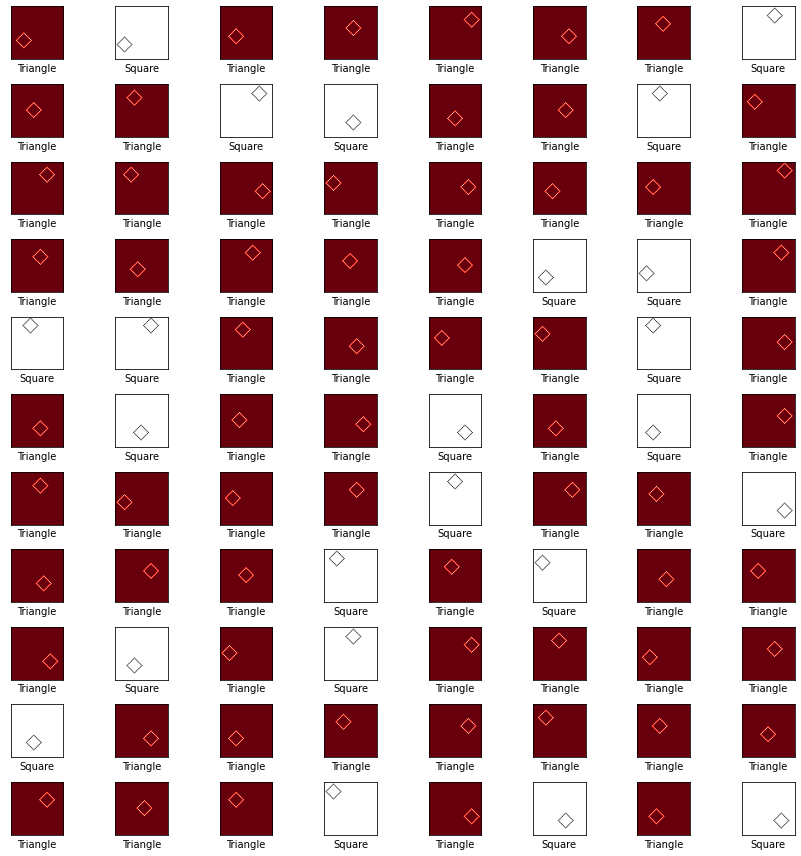

In [14]:
plt.figure(figsize=(12,12))
for i in range(88):
    plt.subplot(11,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cmap = 'gray' if pred_label[i] == 0 else 'Reds'
    plt.imshow(rotated_squares[i], cmap=cmap, vmin=0.0, vmax=1.0)
    plt.xlabel(class_names[pred_label[i]])
plt.tight_layout()
plt.show()

## Why does this matter?

>>> Show wrong "school", "stop" signs, changed stop signs

# Telling squares and triangles apart - part 2

In [15]:
(train_set, train_label), (test_set, test_label) = images.get_color_dataset(10)
class_names = images.get_class_labels()

In [16]:
train_set, train_label = images.prepare_set(train_set, train_label)
test_set, test_label = images.prepare_set(test_set, test_label)

In [17]:
print(train_set.shape, train_set.dtype, train_label.shape, train_label.dtype)
print(test_set.shape, test_set.dtype, test_label.shape, test_label.dtype)

(614, 64, 64, 1) float64 (614, 1) uint8
(67, 64, 64, 1) float64 (67, 1) uint8


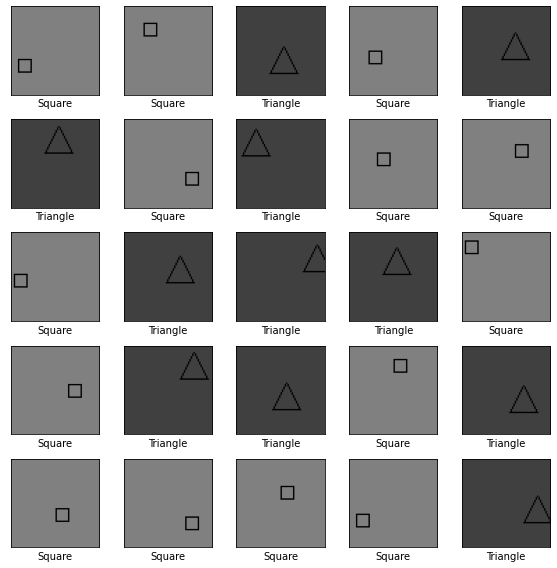

In [18]:
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_set[i], cmap='gray', vmin=0.0, vmax=1.0)
    plt.xlabel(class_names[train_label[i][0]])
plt.tight_layout()
plt.show()

In [19]:
model = get_model()
model.fit(train_set, train_label, batch_size=BATCH_SIZE, epochs=EPOCHS,
          validation_data=(test_set, test_label), callbacks=[callback])

Epoch 1/5
10/10 [==============================] - 2s 213ms/step - loss: 0.7500 - accuracy: 0.5609 - val_loss: 0.4566 - val_accuracy: 0.9403
Epoch 2/5
10/10 [==============================] - 2s 201ms/step - loss: 0.3238 - accuracy: 0.9914 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 3/5
10/10 [==============================] - 2s 194ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 3.0753e-05 - val_accuracy: 1.0000
Epoch 4/5
10/10 [==============================] - 2s 205ms/step - loss: 1.3030e-05 - accuracy: 1.0000 - val_loss: 1.8344e-06 - val_accuracy: 1.0000
Epoch 5/5
10/10 [==============================] - 2s 200ms/step - loss: 1.5381e-06 - accuracy: 1.0000 - val_loss: 7.5796e-07 - val_accuracy: 1.0000


In [20]:
pred_prob = model.predict(test_set)
pred_label = np.argmax(pred_prob, axis=1)

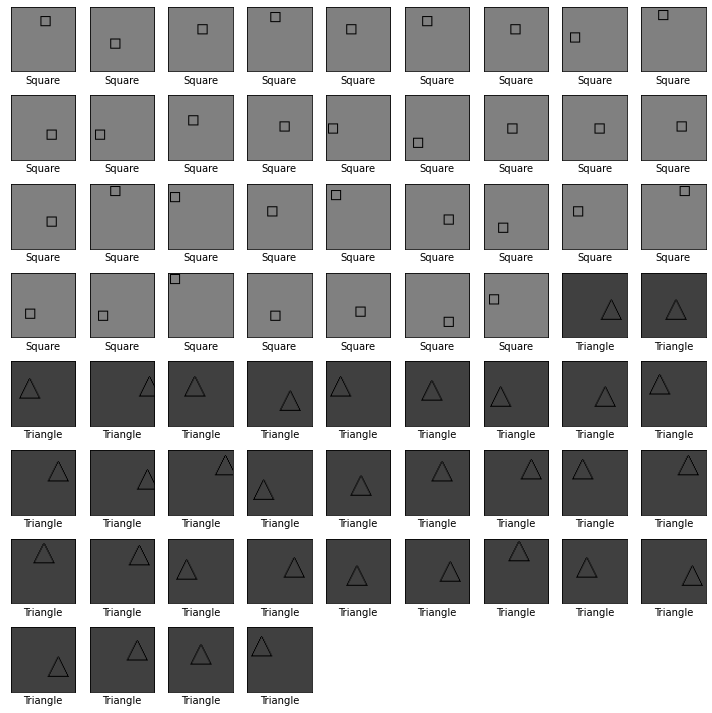

In [21]:
plt.figure(figsize=(10,10))
for i in range(67):
    plt.subplot(8,9,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cmap = 'gray' if pred_label[i] == test_label[i][0] else 'Reds'
    plt.imshow(test_set[i], cmap=cmap, vmin=0.0, vmax=1.0)
    plt.xlabel(class_names[pred_label[i]])
plt.tight_layout()
plt.show()

# In the dark, all squares are triangles

In [22]:
dark_squares = images.get_square_dark_gray_dataset()
dark_squares, _ = images.prepare_set(dark_squares)

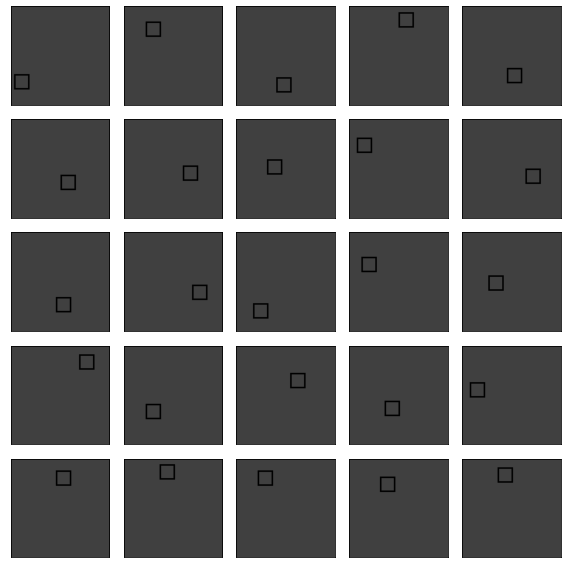

In [23]:
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dark_squares[i], cmap='gray', vmin=0.0, vmax=1.0)
plt.tight_layout()
plt.show()

In [24]:
pred_prob = model.predict(dark_squares)
pred_label = np.argmax(pred_prob, axis=1)

In [25]:
print(pred_label)
print(len(pred_label))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
345


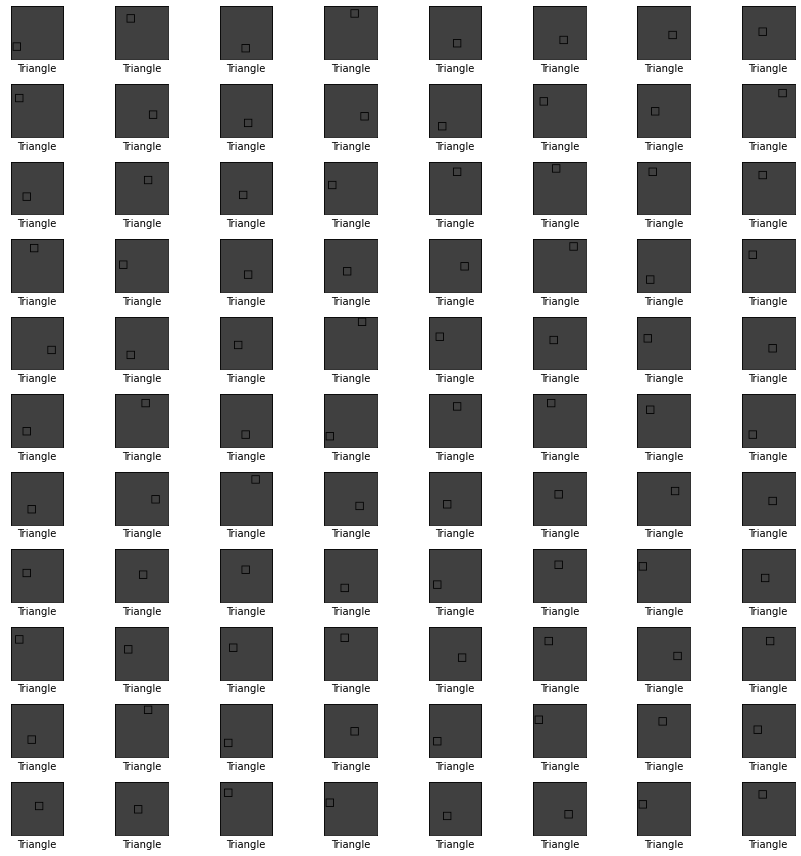

In [26]:
plt.figure(figsize=(12,12))
for i in range(88):
    plt.subplot(11,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dark_squares[i], cmap='gray', vmin=0.0, vmax=1.0)
    plt.xlabel(class_names[pred_label[i]])
plt.tight_layout()
plt.show()

## Why does this matter?

>>> Show poor light conditions failures

# Should we be concerend that deep learning is not "learning"?